[aleju/imgaug: Image augmentation for machine learning experiments.](https://github.com/aleju/imgaug)


### Example: Very Complex Augmentation Pipeline

Apply a very heavy augmentation pipeline to images (used to create the image at the very top of this readme):

In [1]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(64)],
    dtype=np.uint8
)


# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)
#images_aug = seq(images=images)
seq.show_grid([images[0]], cols=10, rows=10)



d:\tool\python36\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
d:\tool\python36\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
d:\tool\python36\lib\site-packages\imgaug\augmenters\segmentation.py:272: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this w

<Figure size 640x640 with 1 Axes>

In [25]:
from PIL import Image
img_path='test_img_cat.jpg'
def load_img(img_path):
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((64, 64), Image.BILINEAR)
    img = np.array(img).astype('float32')
    img = img/255 
    return img
img=load_img(img_path)    

In [24]:
img.shape
img2=Image.fromarray(np.uint8(img*255))
img2.save('22.png')

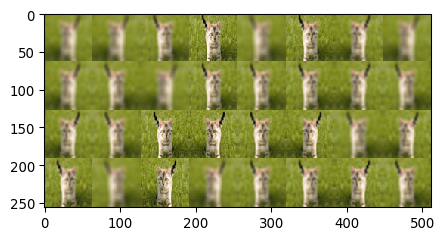

In [15]:
import numpy as np
import imgaug.augmenters as iaa

images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)
seq = iaa.Sequential([iaa.Fliplr(0.5), iaa.GaussianBlur((0, 3.0))])


seq.show_grid([img], cols=8, rows=4)

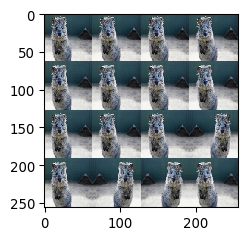

In [19]:
import imgaug as ia
import imgaug.augmenters as iaa

ia.seed(1)#可不要

seq = iaa.Sequential([
    iaa.Fliplr(0.2), # horizontal flips   
    #iaa.Sometimes(0.8,iaa.Crop(percent=(0, 0.1)))
], random_order=True) # apply augmenters in random order

images = np.array(ia.quokka(size=(64, 64)))
#images_aug = seq(images=[images])
seq.show_grid([images], cols=4, rows=4)

## 使用方法
### Sequential按预定的顺序应用

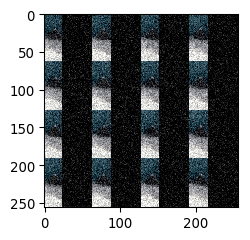

In [18]:
seq = iaa.Sequential([
    iaa.Affine(translate_px={"x":-40}),
    iaa.AdditiveGaussianNoise(scale=0.1*255)
])
seq.show_grid([images], cols=4, rows=4)

### SomeOf((0, None):应用0到最大max个，

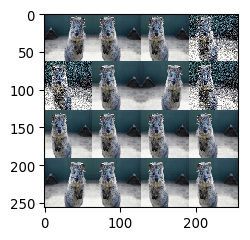

In [23]:
seq = iaa.SomeOf((0, None), [
    #iaa.Affine(rotate=45),
    iaa.Fliplr(),
    iaa.AdditiveGaussianNoise(scale=0.2*255),    
])

seq.show_grid([images], cols=4, rows=4)

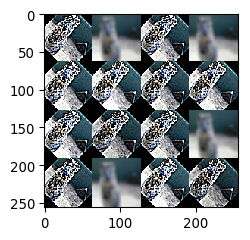

In [24]:
seq = iaa.Sometimes(
      0.5,
      iaa.GaussianBlur(sigma=2.0),#0.5这个
      iaa.Sequential([iaa.Affine(rotate=45), iaa.Sharpen(alpha=1.0)]) #另外0.5这个
  )
seq.show_grid([images],cols=4,rows=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


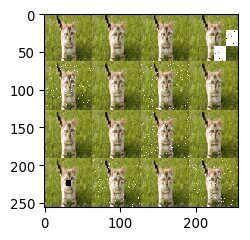

In [67]:
#ia.seed(1)
seq = iaa.Sometimes(0.5,
    iaa.SomeOf(1,[
      iaa.CoarseDropout(0.05, size_percent=0.15),
      #iaa.Pepper(0.02),
      iaa.Salt(0.02),
      iaa.CoarseSaltAndPepper(0.05, size_percent=(0.03, 0.08))
    ]))
img_path='test_img_cat.jpg'
img=load_img(img_path)
seq.show_grid([img],cols=4,rows=4)

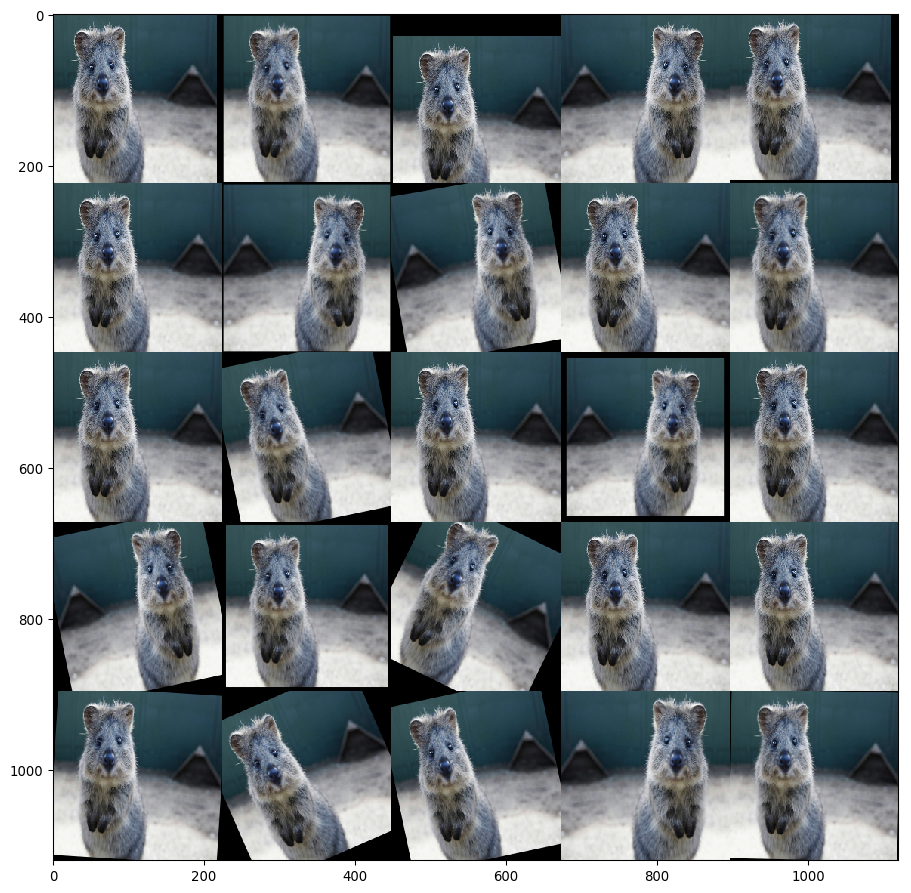

In [18]:
img = np.array(ia.quokka(size=(224, 224)))
seq = iaa.Sequential([
    iaa.Fliplr(0.2), 
    iaa.Sometimes(0.6,
       iaa.OneOf([iaa.Affine(scale=(0.9, 1.1)),
         iaa.Affine(rotate=(-45, 45)),
         iaa.Affine(shear=(-16, 16)),
         iaa.Sequential([
             iaa.PadToFixedSize(width=280, height=280),
             iaa.CropToFixedSize(width=224, height=224)             
         ]),         
       ]),
    ),
    #iaa.Sometimes(0.2,iaa.CoarseSalt(0.01, size_percent=(0.01, 0.05))),
    #iaa.PadToFixedSize(width=280, height=280),
    #iaa.CropToFixedSize(width=224, height=224)
])
seq.show_grid([img],cols=5,rows=5)